In [6]:
Data_dir=r'D:\anime-image-generation\animeimages'

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T 

In [8]:
image_size = 64
batch_size = 128
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [9]:
train_ds = ImageFolder(Data_dir,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)

In [10]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
def denorm (img_tensors):
    return img_tensors*stats[1][0]+stats[0][0]

In [12]:
def show_images(images,nmax=64):
    images.cpu()
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images,_ in  dl:
        show_images(images.cpu(),nmax)
        break

In [13]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

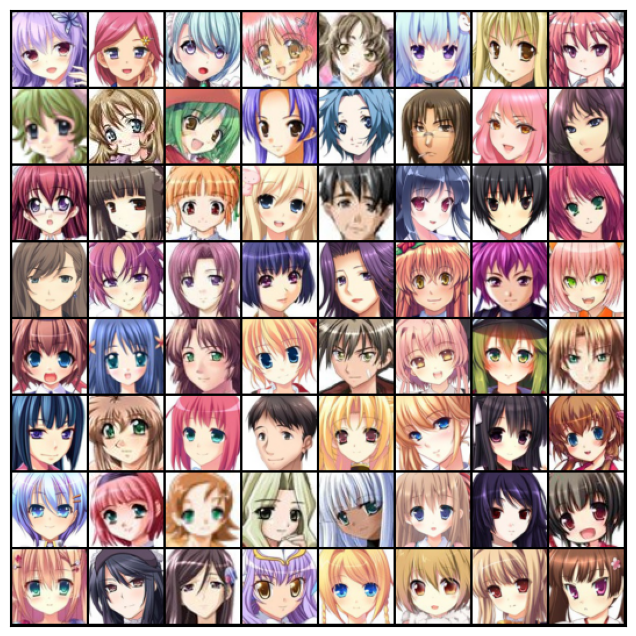

In [14]:
show_batch(train_dl)

In [15]:
def get_default_device():
    """Pick GPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data,device):
    """Moving tensor to the gpu"""
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

class DeviceDataLoader():
    """wraping a dataloader to move data to device"""
    def __init__(self,dl,device):
        self.dl =dl
        self.device=device

    def __iter__(self):
        """Yielding a batch of data"""
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        """number of batches"""
        return len(self.dl)

In [16]:
device=get_default_device()
device

device(type='cuda')

In [17]:
train_dl=DeviceDataLoader(train_dl,device)

Discriminator Network

In [18]:
import torch.nn as nn

In [19]:
discriminator=nn.Sequential(
    #in: 3x64x64
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    #out:64x32x32
    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    #out: 128x16x16
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    #out: 256x8x8
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    #out: 512x4x4
    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),
    #out: 1x1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [20]:
discriminator=to_device(discriminator,device)

Generator Network

In [21]:
latent_size=128

In [22]:
generator=nn.Sequential(
#in: latent_sizex1x1
nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
nn.BatchNorm2d(512),
nn.ReLU(True),

#out: 512x4x4
nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(256),
nn.ReLU(True),

#out:  256x8x8
nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(128),
nn.ReLU(True),

#out: 128x16x16
nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
nn.BatchNorm2d(64),
nn.ReLU(True),

#out: 64x32x32

nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
nn.Tanh()
#out: 3x64x64
)

In [23]:
generator=to_device(generator,device)

torch.Size([128, 3, 64, 64])


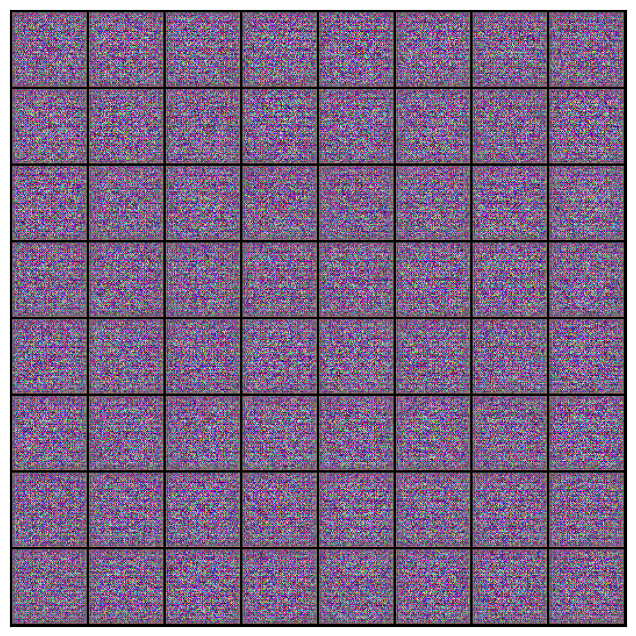

In [24]:
xb=torch.randn(batch_size,latent_size,1,1)
xb=to_device(xb,device)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images.cpu())

Discriminator Training

In [25]:
def train_discriminator(real_images,opt_d):
    #clear discriminator gradients
    opt_d.zero_grad()

    #pass real images through discriminator
    real_preds=discriminator(real_images)
    real_targets=torch.ones(real_images.size(0),1,device=device)
    real_loss=F.binary_cross_entropy(real_preds,real_targets)
    real_score=torch.mean(real_preds).item()

    #generate fake images
    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    latent=to_device(latent,device)
    fake_images=generator(latent)

    #pass fake images through discriminator
    fake_targets=torch.zeros(fake_images.size(0),1,device=device)
    fake_preds=discriminator(fake_images)
    fake_loss=F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score=torch.mean(fake_preds).item()

    #update discriminator weights
    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score

In [26]:
def train_generator(opt_g):
    #clear generator gradients
    opt_g.zero_grad()

    #generate fake images
    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    latent=to_device(latent,device)
    fake_images=generator(latent)

    #try to fool the discriminator
    preds=discriminator(fake_images)
    targets=torch.ones(batch_size,1,device=device)
    loss=F.binary_cross_entropy(preds,targets)

    #update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [27]:
from torchvision.utils import save_image

In [28]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [29]:
def save_samples(index,latent_tensors,show=True):
    fake_images=generator(latent_tensors)
    fake_fname='generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving',fake_fname)
    if show:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [30]:
fixed_latent=torch.randn(batch_size,latent_size,1,1)
fixed_latent=to_device(fixed_latent,device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


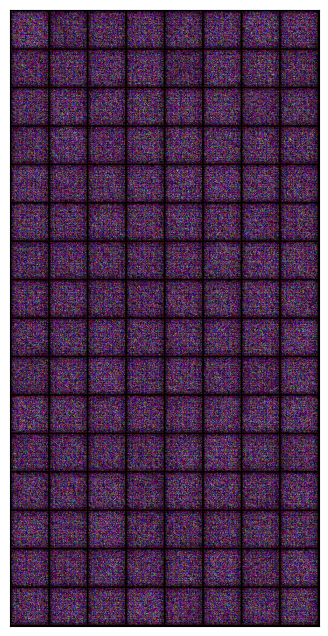

In [31]:
save_samples(0,fixed_latent)

Training loop

In [32]:
import tqdm.notebook
from tqdm.notebook import tqdm
import torch.nn.functional as F


In [33]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()

    #losses & scores
    losses_g=[]
    losses_d=[]
    real_scores=[]
    fake_scores=[]

    #create optimisers
    opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
    opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

    for epoch in range(epochs):
        for real_images,_ in (train_dl):
            #train discriminator
            loss_d,real_score,fake_score=train_discriminator(real_images,opt_d)
            #train generator
            loss_g=train_generator(opt_g)

        #record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        #log losses & scores (last batch)
        print("epoch [{}/{}], loss_g: {:.4f}, loss_d{:.4f}, real_score: {:4f}, fake_score: {:.4f}".format(epoch+1,epochs,loss_g,loss_d,real_score,fake_score))

        #save generated images
        save_samples(epoch+start_idx,fixed_latent,show=False)

    return losses_g,losses_d,real_scores,fake_scores

In [34]:
lr=0.0002
epochs=100

In [43]:
history=fit(epochs,lr)

epoch [1/50], loss_g: 12.4679, loss_d0.0028, real_score: 0.997305, fake_score: 0.0000
Saving generated-images-0001.png
epoch [2/50], loss_g: 12.6456, loss_d0.0009, real_score: 0.999851, fake_score: 0.0007
Saving generated-images-0002.png
epoch [3/50], loss_g: 11.5132, loss_d0.0014, real_score: 0.999109, fake_score: 0.0005
Saving generated-images-0003.png
epoch [4/50], loss_g: 11.3941, loss_d0.0021, real_score: 0.997967, fake_score: 0.0001
Saving generated-images-0004.png
epoch [5/50], loss_g: 18.2481, loss_d0.0009, real_score: 0.999137, fake_score: 0.0000
Saving generated-images-0005.png
epoch [6/50], loss_g: 12.7832, loss_d0.0003, real_score: 0.999754, fake_score: 0.0000
Saving generated-images-0006.png
epoch [7/50], loss_g: 13.0468, loss_d0.0005, real_score: 0.999924, fake_score: 0.0004
Saving generated-images-0007.png
epoch [8/50], loss_g: 17.3502, loss_d0.0013, real_score: 0.998722, fake_score: 0.0000
Saving generated-images-0008.png
epoch [9/50], loss_g: 10.1724, loss_d0.0004, rea

In [41]:
import torch
# Define the path to save/load the model
model_path = "generator_model_asta1.pth"


# Step 2: Save the trained generator model
torch.save(generator, model_path)